# TAREA 3: FEATURE ENGINEERING – PARTE 3

In [54]:
# Cargamos las librerías necesarias
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
# Cargamos el dataset
df = pd.read_csv('pacientes_nutricion.csv')

# Excluimos fecha_registro de los cálculos estadísticos
columna_a_excluir_de_stats = 'fecha_registro'

# Mostrar las primeras 20 filas 
print("="*80)
print("PRIMERAS 20 FILAS DEL DATASET:")
print("="*80)
print(df.head(20).to_string())

# Información básica del dataset 
print("\n" + "="*80)
print("INFORMACIÓN ESTRUCTURAL DEL DATASET:")
print("="*80)
print(df.info())

# Separar columnas numéricas y categóricas
# Obtenemos todas las columnas primero
todas_numericas = df.select_dtypes(include=['number']).columns
todas_categoricas = df.select_dtypes(include=['object', 'category']).columns

# Filtramos 'fecha_registro' de estas listas antes de calcular estadísticas
numericas_para_stats = [col for col in todas_numericas if col != columna_a_excluir_de_stats]
categoricas_para_stats = [col for col in todas_categoricas if col != columna_a_excluir_de_stats]

# Estadísticas descriptivas para variables numéricas
print("\n" + "="*80)
print(f"ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS (excluyendo '{columna_a_excluir_de_stats}' si es numérica):")
print("="*80)
if numericas_para_stats: # Verificamos que la lista no esté vacía
    print(df[numericas_para_stats].describe().to_string())
else:
    print(f"No hay variables numéricas para mostrar (o '{columna_a_excluir_de_stats}' era la única y fue excluida).")


# Estadísticas para variables categóricas (conteo de frecuencias)
print("\n" + "="*80)
print(f"DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS (excluyendo '{columna_a_excluir_de_stats}' si es categórica):")
print("="*80)
if categoricas_para_stats: # Verificamos que la lista no esté vacía
    for col in categoricas_para_stats:
        # Asegurarnos de que la columna todavía existe en el df original antes de accederla
        if col in df.columns:
            print(f"\n{col}:\n" + df[col].value_counts(dropna=False).to_string())
else:
    print(f"No hay variables categóricas para mostrar (o '{columna_a_excluir_de_stats}' era la única y fue excluida).")

# Valores nulos por columna 
print("\n" + "="*80)
print("VALORES NULOS POR COLUMNA:")
print("="*80)
print(df.isnull().sum().to_string())


PRIMERAS 20 FILAS DEL DATASET:
    id_paciente    sexo   edad  peso_kg  altura_cm        IMC  grasa_corporal_pct  masa_muscular_pct nivel_actividad  dias_ejercicio_semana  horas_sueño_promedio fumador bebedor  frecuencia_frutas  frecuencia_verduras  consumo_ultraprocesados  colesterol_hdl  colesterol_ldl  trigliceridos  glucosa  presion_sistolica  presion_diastolica diagnostico_diabetes  riesgo_metabolico fecha_registro
0             1  Female   97.0     77.7      170.1  16.427730                39.7               19.3            ALTO                      5                   5.8      No      no                 20                    4                      9.0            64.6           106.5           95.2     80.1                142                  55                   No                  1     11-26-2024
1             2       M   46.0     65.6      171.8  25.784221                 5.0               16.1            alto                      7                   5.5      no      sí      

In [56]:
# Configuración general de estilo
sns.set(style='whitegrid', palette='Set2')

# Gráfico Distribución de Edad

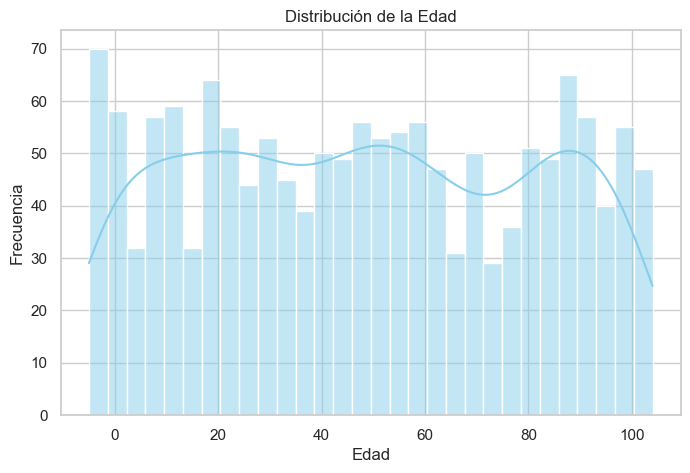

In [57]:
plt.figure(figsize=(8, 5))
sns.histplot(df['edad'], kde=True, bins=30, color='skyblue')
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()


# Gráfico Boxplot del IMC

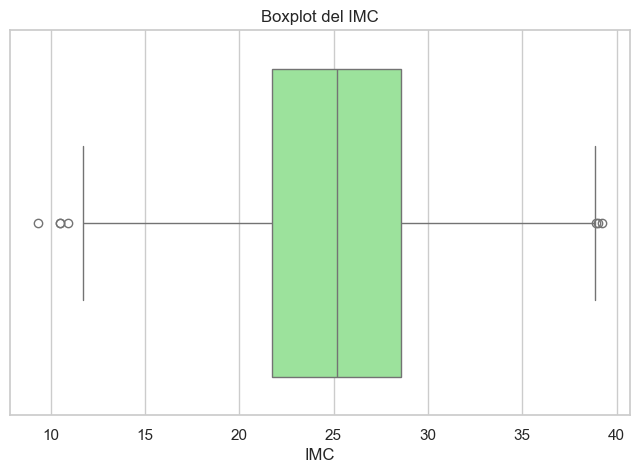

In [58]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['IMC'], color='lightgreen')
plt.title('Boxplot del IMC')
plt.xlabel('IMC')
plt.show()


# Gráfico Conteo de valores en la variable sexo

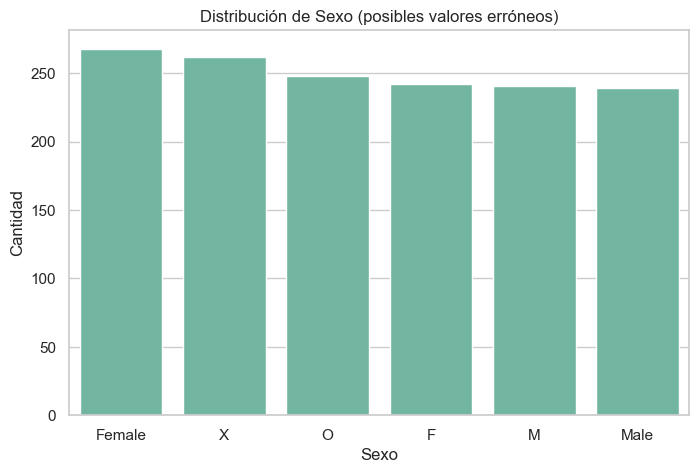

In [59]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sexo', data=df, order=df['sexo'].value_counts().index)
plt.title('Distribución de Sexo (posibles valores erróneos)')
plt.ylabel('Cantidad')
plt.xlabel('Sexo')
plt.show()


# Gráfico Nivel de actividad física

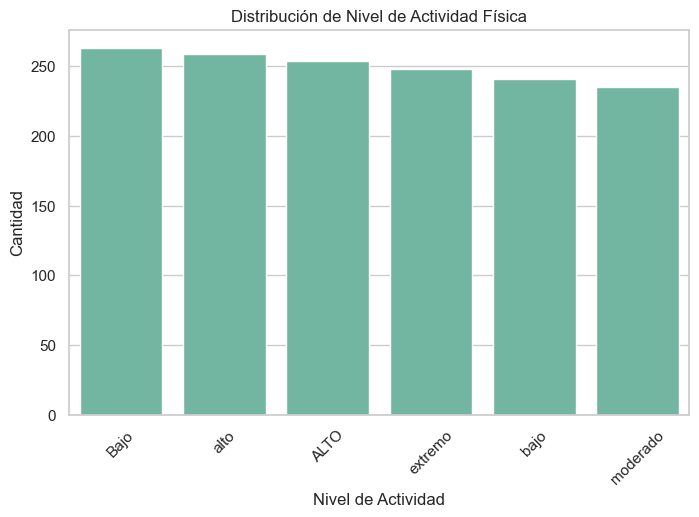

In [60]:
plt.figure(figsize=(8, 5))
sns.countplot(x='nivel_actividad', data=df, order=df['nivel_actividad'].value_counts().index)
plt.title('Distribución de Nivel de Actividad Física')
plt.xticks(rotation=45)
plt.xlabel('Nivel de Actividad')
plt.ylabel('Cantidad')
plt.show()


# Gráfico Correlación entre variables numéricas

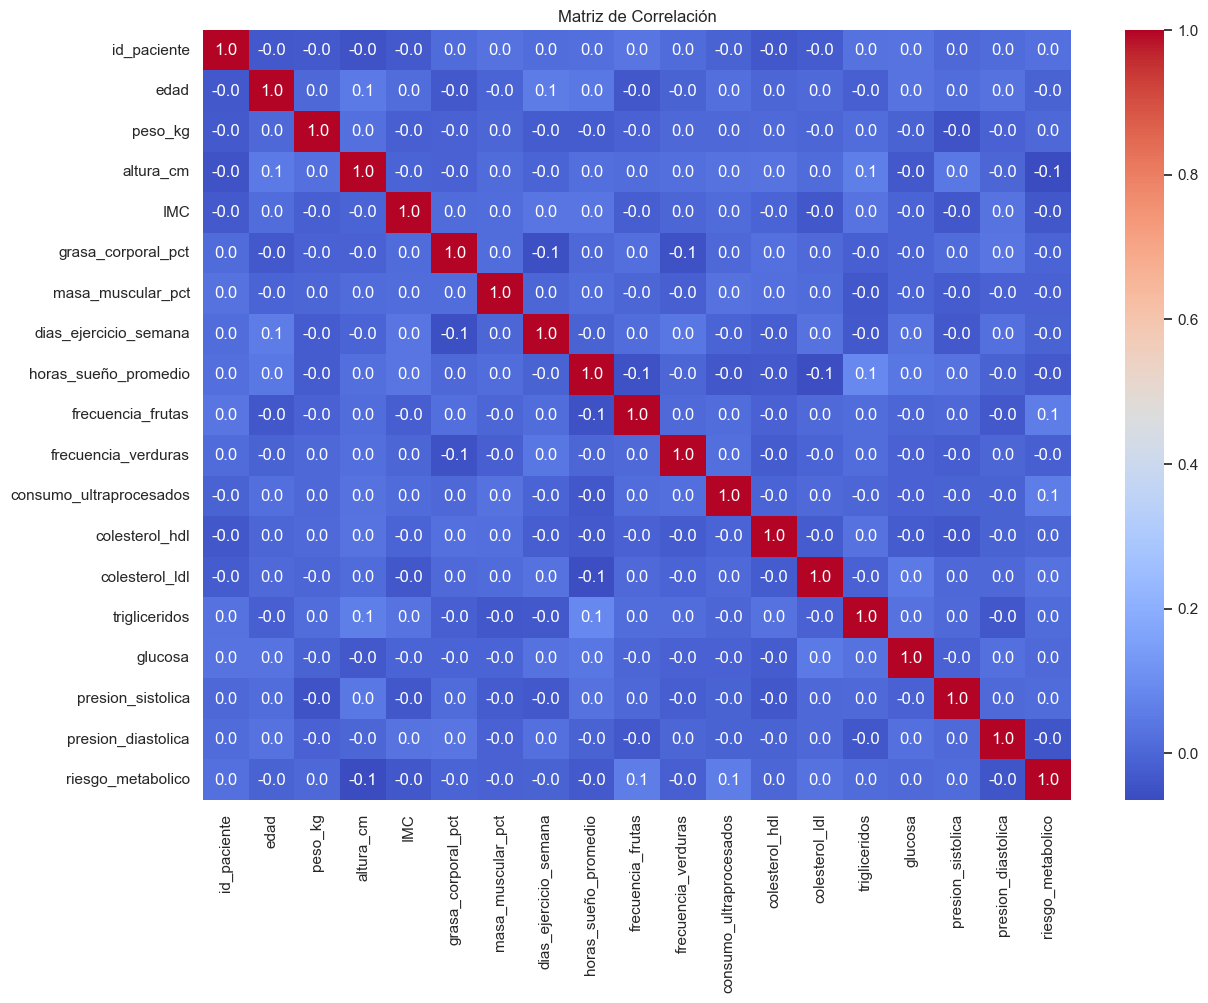

In [61]:
plt.figure(figsize=(14, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Matriz de Correlación')
plt.show()


# Gráfico Distribución de la variable “fumador”

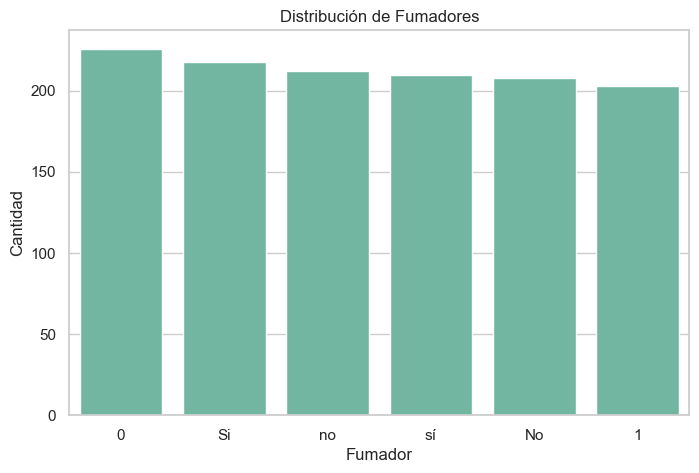

In [62]:
plt.figure(figsize=(8, 5))
sns.countplot(x='fumador', data=df, order=df['fumador'].value_counts().index)
plt.title('Distribución de Fumadores')
plt.xlabel('Fumador')
plt.ylabel('Cantidad')
plt.show()


### Transformaciones a Variables Categóricas

Se realizaron las siguientes transformaciones y limpiezas en las variables categóricas:

* **`sexo`**:
    * Se unificaron los valores: "M" y "Male" a "Male"; "F" y "Female" a "Female".
    * Los valores "O" (Otros) y "X" (Indefinido) se trataron como datos faltantes.
    * Todos los datos faltantes (originales o generados) se imputaron con la moda ("Male" o "Female"), resultando en una columna con solo estas dos categorías.

* **`nivel_actividad`**:
    * Se estandarizaron todos los valores a minúsculas (ej. "ALTO" a "alto") para asegurar consistencia en las categorías: "bajo", "moderado", "alto", "extremo".

* **`fumador`**:
    * Se mapearon los valores a un formato binario numérico: "sí", "Si", "1" se convirtieron a `1`; "no", "No", "0" se convirtieron a `0`.
    * Los valores faltantes (NaN) se imputaron con la moda (0 o 1).
    * La columna se convirtió a tipo entero.

* **`bebedor`**:
    * Se mapearon los valores a un formato binario numérico: variantes de "sí" se convirtieron a `1`; variantes de "no" se convirtieron a `0`.
    * Los valores faltantes (NaN) se imputaron con la moda (0 o 1).
    * La columna se convirtió a tipo entero.

* **`diagnostico_diabetes`**:
    * Se mapearon los valores a un formato binario numérico: variantes de "Sí" se convirtieron a `1`; variantes de "No" se convirtieron a `0`.
    * Los valores faltantes (NaN) se imputaron con la moda (0 o 1).
    * La columna se convirtió a tipo entero.

In [63]:
print("="*80)
print("ESTADO INICIAL DE LAS VARIABLES CATEGÓRICAS A TRANSFORMAR:")
print("="*80)
for col in ['sexo', 'nivel_actividad', 'fumador', 'bebedor', 'diagnostico_diabetes']:
    if col in df.columns:
        print(f"\nValores únicos en '{col}':\n", df[col].value_counts(dropna=False))
    else:
        print(f"\nAdvertencia: La columna '{col}' no se encontró en el DataFrame 'df'.")
print("\n" + "="*80)


# ----- 1. Transformación de 'sexo' -----
print("\nTRANSFORMANDO 'sexo' a 'Male'/'Female'...")
sexo_map = {
    "M": "Male", "Male": "Male",
    "F": "Female", "Female": "Female",
    "O": np.nan,
    "X": np.nan
}
df['sexo'] = df['sexo'].map(sexo_map)

print("Valores en 'sexo' antes de imputar NaN:\n", df['sexo'].value_counts(dropna=False))
if df['sexo'].isnull().sum() > 0:
    moda_sexo = df['sexo'].mode()
    if not moda_sexo.empty:
        df['sexo'].fillna(moda_sexo[0], inplace=True)
        print(f"NaN en 'sexo' imputados con la moda: '{moda_sexo[0]}'")
    else:
        # Caso raro: toda la columna es NaN después del mapeo, o la columna estaba vacía.
        df['sexo'].fillna("Unknown", inplace=True) # O "Male" o "Female" como default
        print("Columna 'sexo' era completamente NaN o vacía después del mapeo. Imputado con 'Unknown'.")
print("Valores en 'sexo' después de la transformación e imputación:\n", df['sexo'].value_counts(dropna=False))


# ----- 2. Transformación de 'nivel_actividad' -----
print("\nTRANSFORMANDO 'nivel_actividad'...")
df['nivel_actividad'] = df['nivel_actividad'].astype(str).str.lower()
print("Valores en 'nivel_actividad' después de la transformación:\n", df['nivel_actividad'].value_counts(dropna=False))


# ----- Función auxiliar para transformar a 0/1 e imputar -----
def transformar_a_binario(df_input, columna, mapa_valores, nombre_col_print=""):
    df_trabajo = df_input # Copia del DataFrame original para evitar modificarlo directamente

    if nombre_col_print == "":
        nombre_col_print = columna
    print(f"\nTRANSFORMANDO '{nombre_col_print}' a 0/1...")

    # La función aún verifica si la columna específica existe en el df que recibe
    if columna not in df_trabajo.columns:
        print(f"Advertencia en transformar_a_binario: Columna '{columna}' no encontrada.")
        return df_trabajo

    df_trabajo[columna] = df_trabajo[columna].astype(str).str.lower().map(mapa_valores)
    print(f"Valores en '{nombre_col_print}' antes de imputar NaN (0/1):\n", df_trabajo[columna].value_counts(dropna=False))

    if df_trabajo[columna].isnull().sum() > 0:
        moda = df_trabajo[columna].mode()
        if not moda.empty:
            df_trabajo[columna].fillna(moda[0], inplace=True)
            print(f"NaN en '{nombre_col_print}' imputados con la moda: {moda[0]}")
        else:
            df_trabajo[columna].fillna(0, inplace=True) # Default si todo es NaN
            print(f"'{nombre_col_print}' consistía solo de NaN o estaba vacía tras mapeo. Imputado con 0.")

    df_trabajo[columna] = pd.to_numeric(df_trabajo[columna], errors='coerce').fillna(0).astype(int)
    print(f"Valores en '{nombre_col_print}' después de la transformación e imputación (0/1):\n", df_trabajo[columna].value_counts(dropna=False))
    print(f"Tipo de dato de '{nombre_col_print}': {df_trabajo[columna].dtype}")
    return df_trabajo

# ----- 3. Transformación de 'fumador' a 0/1 -----
fumador_map_numeric = {"si": 1, "sí": 1, "1": 1, "1.0": 1, "no": 0, "0": 0, "0.0": 0}
df = transformar_a_binario(df, 'fumador', fumador_map_numeric)

# ----- 4. Transformación de 'bebedor' a 0/1 -----
bebedor_map_numeric = {"si": 1, "sí": 1, "no": 0}
df = transformar_a_binario(df, 'bebedor', bebedor_map_numeric)

# ----- 5. Transformación de 'diagnostico_diabetes' a 0/1 -----
diabetes_map_numeric = {"sí": 1, "si": 1, "no": 0} # Mapeo a minúsculas por .str.lower() en la función
df = transformar_a_binario(df, 'diagnostico_diabetes', diabetes_map_numeric, nombre_col_print='diagnostico_diabetes')

# --- Resultados Finales de las Transformaciones Categóricas ---
print("\n" + "="*80)
print("CONTEO DE VALORES NULOS DESPUÉS DE TRANSFORMAR ESTAS CATEGÓRICAS:")
print("="*80)
print(df.isnull().sum().to_string())

print("\n" + "="*80)
print("INFORMACIÓN DEL DATAFRAME DESPUÉS DE TRANSFORMAR ESTAS CATEGÓRICAS:")
print("="*80)
df.info()

print("\n" + "="*80)
print("PRIMERAS FILAS DEL DATAFRAME TRANSFORMADO (para revisión):")
print("="*80)
cols_revisar = [col for col in ['sexo', 'nivel_actividad', 'fumador', 'bebedor', 'diagnostico_diabetes'] if col in df.columns]
other_cols_sample = [col for col in df.columns if col not in cols_revisar][:3]
print(df[cols_revisar + other_cols_sample].head().to_string())

ESTADO INICIAL DE LAS VARIABLES CATEGÓRICAS A TRANSFORMAR:

Valores únicos en 'sexo':
 sexo
Female    268
X         262
O         248
F         242
M         241
Male      239
Name: count, dtype: int64

Valores únicos en 'nivel_actividad':
 nivel_actividad
Bajo        263
alto        259
ALTO        254
extremo     248
bajo        241
moderado    235
Name: count, dtype: int64

Valores únicos en 'fumador':
 fumador
0      226
NaN    223
Si     218
no     212
sí     210
No     208
1      203
Name: count, dtype: int64

Valores únicos en 'bebedor':
 bebedor
NaN    530
sí     490
no     480
Name: count, dtype: int64

Valores únicos en 'diagnostico_diabetes':
 diagnostico_diabetes
No     530
NaN    491
Sí     479
Name: count, dtype: int64


TRANSFORMANDO 'sexo' a 'Male'/'Female'...
Valores en 'sexo' antes de imputar NaN:
 sexo
Female    510
NaN       510
Male      480
Name: count, dtype: int64
NaN en 'sexo' imputados con la moda: 'Female'
Valores en 'sexo' después de la transformación e impu

C:\Users\gabri\AppData\Local\Temp\ipykernel_14064\1099872734.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sexo'].fillna(moda_sexo[0], inplace=True)
C:\Users\gabri\AppData\Local\Temp\ipykernel_14064\1099872734.py:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

In [64]:
# --- Descriptivas Iniciales de Variables Numéricas ---
print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS (ANTES DE TRANSFORMACIÓN):")
print("="*80)
numeric_cols_to_describe = ['edad', 'peso_kg', 'altura_cm', 'IMC', 'grasa_corporal_pct',
                            'masa_muscular_pct', 'dias_ejercicio_semana', 'horas_sueño_promedio',
                            'consumo_ultraprocesados', 'colesterol_hdl', 'colesterol_ldl',
                            'trigliceridos', 'glucosa', 'presion_sistolica', 'presion_diastolica']
# Filtrar por columnas que existen en el df para evitar errores
numeric_cols_to_describe = [col for col in numeric_cols_to_describe if col in df.columns]
if numeric_cols_to_describe:
    print(df[numeric_cols_to_describe].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).to_string())
else:
    print("No se encontraron las columnas numéricas esperadas para describir.")

# --- 1. Correcciones de Unidades y Errores Obvios ---

# Glucosa
if 'glucosa' in df.columns:
    print("\nTransformando 'glucosa'...")
    conversion_factor_glucosa = 18.0182
    df.loc[df['glucosa'] < 35, 'glucosa'] = df.loc[df['glucosa'] < 35, 'glucosa'] * conversion_factor_glucosa
    print(f"Valores de glucosa < 35 han sido multiplicados por {conversion_factor_glucosa}.")

# Edad
if 'edad' in df.columns:
    print("\nLimpiando 'edad'...")
    df.loc[df['edad'] < 0, 'edad'] = np.nan
    df.loc[df['edad'] > 105, 'edad'] = np.nan
    print("Edades < 0 y > 105 convertidas a NaN.")

# Masa Muscular Pct
if 'masa_muscular_pct' in df.columns:
    print("\nLimpiando 'masa_muscular_pct'...")
    df.loc[df['masa_muscular_pct'] > 100, 'masa_muscular_pct'] = np.nan
    print("Valores de 'masa_muscular_pct' > 100% convertidos a NaN.")

# Días Ejercicio Semana
if 'dias_ejercicio_semana' in df.columns:
    print("\nLimpiando 'dias_ejercicio_semana'...")
    df.loc[df['dias_ejercicio_semana'] > 7, 'dias_ejercicio_semana'] = 7
    print("Valores de 'dias_ejercicio_semana' > 7 capados a 7.")

# --- 2. Recálculo de IMC ---
if 'peso_kg' in df.columns and 'altura_cm' in df.columns and 'IMC' in df.columns:
    print("\nRecalculando 'IMC'...")
    df.loc[df['altura_cm'] == 0, 'altura_cm'] = np.nan
    # Solo recalcular si altura_cm no es NaN y es positiva
    mask_altura_valida = (df['altura_cm'].notna()) & (df['altura_cm'] > 0)
    df['IMC_recalculado'] = np.nan # Inicializar
    df.loc[mask_altura_valida, 'IMC_recalculado'] = df.loc[mask_altura_valida, 'peso_kg'] / ((df.loc[mask_altura_valida, 'altura_cm'] / 100) ** 2)
    
    df['IMC'].fillna(df['IMC_recalculado'], inplace=True)
    df.drop(columns=['IMC_recalculado'], inplace=True)
    print("IMC recalculado donde 'altura_cm' y 'peso_kg' lo permiten y NaNs en IMC original rellenados.")

# --- 3. Imputación de Valores Nulos (con Mediana) ---
cols_to_impute_median = ['edad', 'IMC', 'consumo_ultraprocesados', 'masa_muscular_pct', 'altura_cm'] # Añadido altura_cm por si se hizo 0->NaN
print("\nImputando NaNs con la mediana...")
for col in cols_to_impute_median:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"NaNs en '{col}' imputados con la mediana ({median_val:.2f}).")

# --- 4. Manejo de Valores Atípicos y Rangos (Capping) ---
print("\nAplicando capping a rangos...")

if 'edad' in df.columns:
    df['edad'] = np.clip(df['edad'], 0, 100)
    print("Columna 'edad' capada entre 0 y 100.")

if 'grasa_corporal_pct' in df.columns:
    df['grasa_corporal_pct'] = np.clip(df['grasa_corporal_pct'], 0, 70)
    print("Columna 'grasa_corporal_pct' capada entre 0 y 70.")

if 'masa_muscular_pct' in df.columns:
    df['masa_muscular_pct'] = np.clip(df['masa_muscular_pct'], 0, 75)
    print("Columna 'masa_muscular_pct' capada entre 0 y 75.")

if 'horas_sueño_promedio' in df.columns:
    df['horas_sueño_promedio'] = np.clip(df['horas_sueño_promedio'], 1, 18)
    print("Columna 'horas_sueño_promedio' capada entre 1 y 18.")

if 'consumo_ultraprocesados' in df.columns:
    df['consumo_ultraprocesados'] = np.clip(df['consumo_ultraprocesados'], 0, 30)
    print("Columna 'consumo_ultraprocesados' capada entre 0 y 30.")

if 'trigliceridos' in df.columns:
    df['trigliceridos'] = np.clip(df['trigliceridos'], 0, 600)
    print("Columna 'trigliceridos' capada entre 0 y 600.")

if 'presion_sistolica' in df.columns:
    df['presion_sistolica'] = np.clip(df['presion_sistolica'], 70, 250)
    print("Columna 'presion_sistolica' capada entre 70 y 250.")

if 'presion_diastolica' in df.columns:
    df['presion_diastolica'] = np.clip(df['presion_diastolica'], 40, 140)
    print("Columna 'presion_diastolica' capada entre 40 y 140.")

# --- MODIFICACIÓN: Tratamiento de Presión Arterial Inconsistente ---
if 'presion_sistolica' in df.columns and 'presion_diastolica' in df.columns:
    invalid_pressure_condition = df['presion_sistolica'] <= df['presion_diastolica']
    num_invalid_pressure = invalid_pressure_condition.sum()

    if num_invalid_pressure > 0:
        print(f"\nDetectadas {num_invalid_pressure} filas con presion_sistolica <= presion_diastolica.")
        print("Estableciendo estos valores de presión arterial inconsistentes a NaN.")
        df.loc[invalid_pressure_condition, ['presion_sistolica', 'presion_diastolica']] = np.nan

        # Imputar con la mediana (las medianas se calculan de los valores restantes, ignorando los NaNs recién creados)
        print("Imputando valores de presión arterial convertidos a NaN con la mediana.")
        if df['presion_sistolica'].isnull().any(): # Verificar si hay NaNs para imputar
            median_sistolica = df['presion_sistolica'].median() # Calcula la mediana de los valores válidos
            df['presion_sistolica'].fillna(median_sistolica, inplace=True)
            print(f"NaNs en 'presion_sistolica' (por inconsistencia) imputados con la mediana ({median_sistolica:.2f}).")
        
        if df['presion_diastolica'].isnull().any(): # Verificar si hay NaNs para imputar
            median_diastolica = df['presion_diastolica'].median() # Calcula la mediana de los valores válidos
            df['presion_diastolica'].fillna(median_diastolica, inplace=True)
            print(f"NaNs en 'presion_diastolica' (por inconsistencia) imputados con la mediana ({median_diastolica:.2f}).")
# --- FIN DE MODIFICACIÓN ---

# --- 5. Conversión de Tipos ---
print("\nConvirtiendo tipos de datos...")
cols_to_int = ['edad', 'dias_ejercicio_semana', 'consumo_ultraprocesados']
# Añadir presiones si quieres que sean enteras, aunque usualmente se dejan como float tras imputación con mediana
# cols_to_int.extend(['presion_sistolica', 'presion_diastolica'])
for col in cols_to_int:
    if col in df.columns:
        if not df[col].isnull().any(): # Asegurar que no queden NaNs
            try:
                df[col] = df[col].astype(int)
                print(f"Columna '{col}' convertida a tipo int.")
            except ValueError:
                print(f"Error al convertir '{col}' a int. Podría contener NaNs o valores no convertibles.")
        else:
            print(f"Columna '{col}' no convertida a int porque aún contiene NaNs.")


# --- Descriptivas Finales de Variables Numéricas ---
print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS (DESPUÉS DE TRANSFORMACIÓN):")
print("="*80)
if numeric_cols_to_describe: # Reusar la lista de columnas numéricas
    print(df[numeric_cols_to_describe].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).to_string())
else:
    print("No se encontraron las columnas numéricas esperadas para describir.")

# --- AÑADIDO: Impresiones Finales de Nulos e Info ---
print("\n" + "="*80)
print("CONTEO DE VALORES NULOS (DESPUÉS DE TRANSFORMAR NUMÉRICAS):")
print("="*80)
print(df.isnull().sum().to_string())

print("\n" + "="*80)
print("INFORMACIÓN DEL DATAFRAME (DESPUÉS DE TRANSFORMAR NUMÉRICAS):")
print("="*80)
df.info()


ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS (ANTES DE TRANSFORMACIÓN):
              edad      peso_kg    altura_cm          IMC  grasa_corporal_pct  masa_muscular_pct  dias_ejercicio_semana  horas_sueño_promedio  consumo_ultraprocesados  colesterol_hdl  colesterol_ldl  trigliceridos      glucosa  presion_sistolica  presion_diastolica
count  1483.000000  1500.000000  1500.000000  1365.000000         1500.000000        1500.000000            1500.000000           1500.000000              1453.000000     1500.000000     1500.000000     1500.00000  1500.000000        1500.000000         1500.000000
mean     48.406608    70.901333   169.963800    25.135759           25.133067          34.971867               4.418000              6.957000                14.746731       49.920800       98.555733      149.78220    80.824534         140.126000           89.241333
std      32.122675    15.027302    10.027143     5.018015            9.694352          16.246383               2.855996      

C:\Users\gabri\AppData\Local\Temp\ipykernel_14064\3738387939.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['IMC'].fillna(df['IMC_recalculado'], inplace=True)
C:\Users\gabri\AppData\Local\Temp\ipykernel_14064\3738387939.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



# Defir las clases y funciones para los transformadores.

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

In [66]:
# --- Transformadores para Variables Categóricas ---

class SexoTransformer(BaseEstimator, TransformerMixin):
    """Transforma la columna 'sexo' a 'Male'/'Female' e imputa NaNs con la moda."""
    def __init__(self):
        self.mode_ = None
        self.sexo_map_ = {"M": "Male", "Male": "Male", "F": "Female", "Female": "Female", "O": np.nan, "X": np.nan}

    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=['sexo'])
        temp_sexo_col = X_df['sexo'].map(self.sexo_map_)
        self.mode_ = temp_sexo_col.mode()[0] if not temp_sexo_col.mode().empty else "Unknown"
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=['sexo'])
        X_df['sexo'] = X_df['sexo'].map(self.sexo_map_)
        X_df['sexo'].fillna(self.mode_, inplace=True)
        return X_df # Retorna DataFrame para mantener el nombre de la columna

# Para nivel_actividad: FunctionTransformer
def lowercase_transformer(series):
    return series.astype(str).str.lower().to_frame() # to_frame para asegurar salida DataFrame

nivel_actividad_transformer = FunctionTransformer(lowercase_transformer)


class BinaryEncoderTransformer(BaseEstimator, TransformerMixin):
    """Convierte columnas categóricas binarias (sí/no, 1/0) a 0/1 e imputa con la moda."""
    def __init__(self, map_dict):
        self.map_dict = map_dict
        self.mode_ = None

    def fit(self, X, y=None): # X es una serie
        temp_col = X.astype(str).str.lower().map(self.map_dict)
        self.mode_ = temp_col.mode()[0] if not temp_col.mode().empty else 0 # Default a 0
        return self

    def transform(self, X): # X es una serie
        X_transformed = X.astype(str).str.lower().map(self.map_dict)
        X_transformed.fillna(self.mode_, inplace=True)
        return X_transformed.astype(int).to_frame() # to_frame para asegurar salida DataFrame

# Diccionarios de mapeo para columnas binarias (actualizados para la función)
fumador_map_to_1_0 = {"si": 1, "sí": 1, "1": 1, "1.0": 1, "no": 0, "0": 0, "0.0": 0}
bebedor_map_to_1_0 = {"si": 1, "sí": 1, "no": 0}
diabetes_map_to_1_0 = {"sí": 1, "si": 1, "no": 0}


# --- Transformadores para Variables Numéricas ---

class InitialPointwiseCleaner(BaseEstimator, TransformerMixin):
    """Aplica correcciones puntuales iniciales a columnas numéricas."""
    def __init__(self, glucosa_threshold=35, glucosa_factor=18.0182,
                 edad_min_abs=0, edad_max_nan=105, mmp_max_nan=100, dias_ej_max_cap=7):
        self.glucosa_threshold = glucosa_threshold
        self.glucosa_factor = glucosa_factor
        self.edad_min_abs = edad_min_abs
        self.edad_max_nan = edad_max_nan
        self.mmp_max_nan = mmp_max_nan
        self.dias_ej_max_cap = dias_ej_max_cap

    def fit(self, X, y=None):
        return self # No necesita aprender nada de los datos

    def transform(self, X):
        X_transformed = X.copy() # X es un DataFrame de columnas numéricas
        if 'glucosa' in X_transformed.columns:
            X_transformed.loc[X_transformed['glucosa'] < self.glucosa_threshold, 'glucosa'] *= self.glucosa_factor
        if 'edad' in X_transformed.columns:
            X_transformed.loc[X_transformed['edad'] < self.edad_min_abs, 'edad'] = np.nan
            X_transformed.loc[X_transformed['edad'] > self.edad_max_nan, 'edad'] = np.nan
        if 'masa_muscular_pct' in X_transformed.columns:
            X_transformed.loc[X_transformed['masa_muscular_pct'] > self.mmp_max_nan, 'masa_muscular_pct'] = np.nan
        if 'dias_ejercicio_semana' in X_transformed.columns:
            X_transformed.loc[X_transformed['dias_ejercicio_semana'] > self.dias_ej_max_cap, 'dias_ejercicio_semana'] = self.dias_ej_max_cap
        if 'altura_cm' in X_transformed.columns:
            X_transformed.loc[X_transformed['altura_cm'] == 0, 'altura_cm'] = np.nan
        return X_transformed

class IMCCalculator(BaseEstimator, TransformerMixin):
    """Calcula IMC y rellena NaNs en la columna IMC existente."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy() # X es un DataFrame
        if 'peso_kg' in X_transformed.columns and \
           'altura_cm' in X_transformed.columns and \
           'IMC' in X_transformed.columns:
            
            mask_altura_valida = (X_transformed['altura_cm'].notna()) & (X_transformed['altura_cm'] > 0)
            imc_recalculated = pd.Series(np.nan, index=X_transformed.index)
            
            imc_recalculated.loc[mask_altura_valida] = X_transformed.loc[mask_altura_valida, 'peso_kg'] / \
                                                      ((X_transformed.loc[mask_altura_valida, 'altura_cm'] / 100) ** 2)
            
            X_transformed['IMC'].fillna(imc_recalculated, inplace=True)
        return X_transformed

class ValueRangeCapper(BaseEstimator, TransformerMixin):
    """Aplica np.clip para capar valores a un min y max definidos por columna."""
    def __init__(self, cap_configs):
        # cap_configs: {'col_name': (min_val, max_val), ...}
        self.cap_configs = cap_configs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy() # X es un DataFrame
        for col, (min_val, max_val) in self.cap_configs.items():
            if col in X_transformed.columns:
                X_transformed[col] = np.clip(X_transformed[col], min_val, max_val)
        return X_transformed

class BloodPressureImputer(BaseEstimator, TransformerMixin):
    """Maneja inconsistencias en presión arterial (sistólica <= diastólica)
       poniendo a NaN e imputando con la mediana aprendida."""
    def __init__(self):
        self.median_sistolica_ = None
        self.median_diastolica_ = None

    def fit(self, X, y=None): # X es un DataFrame
        X_temp = X.copy()
        if 'presion_sistolica' in X_temp.columns and 'presion_diastolica' in X_temp.columns:
            # Calcula medianas antes de la modificación para no sesgarlas si hay muchos NaNs
            
            # Simular el estado después de que los valores inconsistentes se vuelven NaN para el cálculo de la mediana
            invalid_pressure_condition_fit = X_temp['presion_sistolica'] <= X_temp['presion_diastolica']
            X_temp.loc[invalid_pressure_condition_fit, 'presion_sistolica'] = np.nan
            X_temp.loc[invalid_pressure_condition_fit, 'presion_diastolica'] = np.nan
            
            if X_temp['presion_sistolica'].notna().any(): # Solo si hay valores no-NaN
                 self.median_sistolica_ = X_temp['presion_sistolica'].median()
            else: # Si todos son NaN
                self.median_sistolica_ = 120 # Un default razonable

            if X_temp['presion_diastolica'].notna().any():
                self.median_diastolica_ = X_temp['presion_diastolica'].median()
            else:
                self.median_diastolica_ = 80 # Un default razonable
        return self

    def transform(self, X):
        X_transformed = X.copy() # X es un DataFrame
        if 'presion_sistolica' in X_transformed.columns and 'presion_diastolica' in X_transformed.columns:
            invalid_pressure_condition = X_transformed['presion_sistolica'] <= X_transformed['presion_diastolica']
            num_invalid = invalid_pressure_condition.sum()

            if num_invalid > 0:
                X_transformed.loc[invalid_pressure_condition, ['presion_sistolica', 'presion_diastolica']] = np.nan
                
                if self.median_sistolica_ is not None:
                    X_transformed['presion_sistolica'].fillna(self.median_sistolica_, inplace=True)
                if self.median_diastolica_ is not None:
                    X_transformed['presion_diastolica'].fillna(self.median_diastolica_, inplace=True)
        return X_transformed

# Para conversión de tipos: FunctionTransformer
def convert_to_int(df_subset, cols_to_convert):
    df_out = df_subset.copy()
    for col in cols_to_convert:
        if col in df_out.columns and not df_out[col].isnull().any():
            try:
                df_out[col] = df_out[col].astype(int)
            except ValueError:
                print(f"Advertencia: No se pudo convertir la columna {col} a entero.") 
    return df_out

# Definir las Listas de Columnas y Configuraciones

In [67]:
# Columnas categóricas
cat_cols_sexo = ['sexo']
cat_cols_nivel_actividad = ['nivel_actividad']
cat_cols_fumador = ['fumador']
cat_cols_bebedor = ['bebedor']
cat_cols_diabetes = ['diagnostico_diabetes']

# Columnas numéricas (lista completa que pasará por el pipeline numérico)
numerical_cols = ['edad', 'peso_kg', 'altura_cm', 'IMC', 'grasa_corporal_pct',
                  'masa_muscular_pct', 'dias_ejercicio_semana', 'horas_sueño_promedio',
                  'consumo_ultraprocesados', 'colesterol_hdl', 'colesterol_ldl',
                  'trigliceridos', 'glucosa', 'presion_sistolica', 'presion_diastolica']

# Columnas para imputación con mediana (después de correcciones iniciales e IMC)
cols_to_impute_median_list = ['edad', 'IMC', 'consumo_ultraprocesados', 'masa_muscular_pct', 'altura_cm']

# Configuraciones para el ValueRangeCapper
cap_configurations = {
    'edad': (0, 100),
    'grasa_corporal_pct': (0, 70),
    'masa_muscular_pct': (0, 75),
    'horas_sueño_promedio': (1, 18),
    'consumo_ultraprocesados': (0, 30),
    'trigliceridos': (0, 600),
    'presion_sistolica': (70, 250),
    'presion_diastolica': (40, 140)
}

# Columnas para convertir a entero al final
final_int_cols = ['edad', 'dias_ejercicio_semana', 'consumo_ultraprocesados']

# Creación del Pipeline Numérico

In [68]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

In [69]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class MedianImputerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute):
        self.columns_to_impute = columns_to_impute
        self.medians_ = {}

    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        for col in self.columns_to_impute:
            if col in X_df.columns:
                self.medians_[col] = X_df[col].median()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        if not isinstance(X_transformed, pd.DataFrame):
             print("Advertencia: MedianImputerTransformer recibió un input que no es DataFrame en transform.")
             if isinstance(X_transformed, np.ndarray) and hasattr(X_transformed, 'shape') and X_transformed.ndim == 2 and X_transformed.shape[1] == len(self.columns_to_impute):
                 try:
                     X_transformed = pd.DataFrame(X_transformed, columns=self.columns_to_impute)
                 except Exception as e:
                     print(f"No se pudo convertir el ndarray a DataFrame con las columnas especificadas: {e}")


        for col in self.columns_to_impute:
            if col in X_transformed.columns and col in self.medians_:
                X_transformed[col].fillna(self.medians_[col], inplace=True)
        return X_transformed

In [70]:
numerical_pipeline = Pipeline([
    ('initial_cleaner', InitialPointwiseCleaner()),
    ('imc_calculator', IMCCalculator()),
    ('median_imputer', MedianImputerTransformer(columns_to_impute=cols_to_impute_median_list)),
    ('value_capper', ValueRangeCapper(cap_configs=cap_configurations)),
    ('bp_imputer', BloodPressureImputer()),
    ('type_converter', FunctionTransformer(convert_to_int, kw_args={'cols_to_convert': final_int_cols}))
])

# Creación del ColumnTransformer Principal

In [71]:
preprocessor = ColumnTransformer(
    transformers=[
        ('sex', SexoTransformer(), cat_cols_sexo),
        ('actividad', nivel_actividad_transformer, cat_cols_nivel_actividad),
        ('fumador', BinaryEncoderTransformer(map_dict=fumador_map_to_1_0), cat_cols_fumador),
        ('bebedor', BinaryEncoderTransformer(map_dict=bebedor_map_to_1_0), cat_cols_bebedor),
        ('diabetes', BinaryEncoderTransformer(map_dict=diabetes_map_to_1_0), cat_cols_diabetes),
        ('num', numerical_pipeline, numerical_cols) 
    ],
    remainder='passthrough' 
)

# Aplicar el Pipeline

In [72]:
# --- Transformadores para Variables Categóricas ---

class SexoTransformer(BaseEstimator, TransformerMixin):
    """Transforma la columna 'sexo' a 'Male'/'Female' e imputa NaNs con la moda."""
    def __init__(self):
        self.mode_ = None
        self.sexo_map_ = {"M": "Male", "Male": "Male", "F": "Female", "Female": "Female", "O": np.nan, "X": np.nan}

    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=['sexo'])
        temp_sexo_col = X_df['sexo'].map(self.sexo_map_)
        self.mode_ = temp_sexo_col.mode()[0] if not temp_sexo_col.mode().empty else "Unknown"
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=['sexo'])
        X_df['sexo'] = X_df['sexo'].map(self.sexo_map_)
        X_df['sexo'].fillna(self.mode_, inplace=True)
        return X_df

    def set_output(self, *, transform=None):
        return self

class BinaryEncoderTransformer(BaseEstimator, TransformerMixin):
    """Convierte columnas categóricas binarias (sí/no, 1/0) a 0/1 e imputa con la moda."""
    def __init__(self, map_dict):
        self.map_dict = map_dict
        self.mode_ = None

    def fit(self, X, y=None): # X es una serie
        temp_col = X.astype(str).str.lower().map(self.map_dict)
        self.mode_ = temp_col.mode()[0] if not temp_col.mode().empty else 0
        return self

    def transform(self, X): # X es una serie
        X_transformed = X.astype(str).str.lower().map(self.map_dict)
        X_transformed.fillna(self.mode_, inplace=True)
        return X_transformed.astype(int).to_frame()

    def set_output(self, *, transform=None):
        return self

# --- Transformadores para Variables Numéricas ---

class InitialPointwiseCleaner(BaseEstimator, TransformerMixin):
    """Aplica correcciones puntuales iniciales a columnas numéricas."""
    def __init__(self, glucosa_threshold=35, glucosa_factor=18.0182,
                 edad_min_abs=0, edad_max_nan=105, mmp_max_nan=100, dias_ej_max_cap=7):
        self.glucosa_threshold = glucosa_threshold
        self.glucosa_factor = glucosa_factor
        self.edad_min_abs = edad_min_abs
        self.edad_max_nan = edad_max_nan
        self.mmp_max_nan = mmp_max_nan
        self.dias_ej_max_cap = dias_ej_max_cap

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        if 'glucosa' in X_transformed.columns:
            X_transformed.loc[X_transformed['glucosa'] < self.glucosa_threshold, 'glucosa'] *= self.glucosa_factor
        if 'edad' in X_transformed.columns:
            X_transformed.loc[X_transformed['edad'] < self.edad_min_abs, 'edad'] = np.nan
            X_transformed.loc[X_transformed['edad'] > self.edad_max_nan, 'edad'] = np.nan
        if 'masa_muscular_pct' in X_transformed.columns:
            X_transformed.loc[X_transformed['masa_muscular_pct'] > self.mmp_max_nan, 'masa_muscular_pct'] = np.nan
        if 'dias_ejercicio_semana' in X_transformed.columns:
            X_transformed.loc[X_transformed['dias_ejercicio_semana'] > self.dias_ej_max_cap, 'dias_ejercicio_semana'] = self.dias_ej_max_cap
        if 'altura_cm' in X_transformed.columns:
            X_transformed.loc[X_transformed['altura_cm'] == 0, 'altura_cm'] = np.nan
        return X_transformed

    def set_output(self, *, transform=None):
        return self

class IMCCalculator(BaseEstimator, TransformerMixin):
    """Calcula IMC y rellena NaNs en la columna IMC existente."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed

In [73]:
if 'riesgo_metabolico' in df.columns:
    X = df.drop('riesgo_metabolico', axis=1)
    y = df['riesgo_metabolico']
else:
    X = df.copy()

try:
    preprocessor.set_output(transform="pandas")
    X_prepared_df = preprocessor.fit_transform(X)
except AttributeError:
    print("Advertencia: preprocessor.set_output no disponible. La salida será un array NumPy.")
    X_prepared_numpy = preprocessor.fit_transform(X)
    try:
        feature_names = preprocessor.get_feature_names_out()
        X_prepared_df = pd.DataFrame(X_prepared_numpy, columns=feature_names, index=X.index)
    except Exception as e:
        print(f"No se pudo reconstruir el DataFrame automáticamente: {e}")
        print("X_prepared_numpy contiene los datos procesados como array.")
        X_prepared_df = pd.DataFrame(X_prepared_numpy, index=X.index)

if isinstance(X_prepared_df, pd.DataFrame):
    print("\n--- Datos Preparados (DataFrame) ---")
    print(X_prepared_df.head().to_string())
    print("\nInfo de datos preparados:")
    X_prepared_df.info()
    print("\nDescripción de datos preparados (numéricos):")
    prepared_num_cols = [col for col in X_prepared_df.columns if pd.api.types.is_numeric_dtype(X_prepared_df[col])]
    if prepared_num_cols:
        print(X_prepared_df[prepared_num_cols].describe().to_string())
    else:
        print("No hay columnas numéricas en la salida preparada para describir.")
else:
     print("\n--- Datos Preparados (NumPy array) ---")
     print(X_prepared_numpy[:5])

ValueError: Unable to configure output for SexoTransformer() because `set_output` is not available.

# Interrogantes:

### ¿Cuántos pacientes tienen valores extremos en triglicéridos? 

### ¿Cuál es la proporción de pacientes con glucosa medida en mmol/L?

### ¿Qué transformaciones aplicarías para estandarizar los datos faltantes? 

### ¿Cuál sería una nueva variable útil? (Ej: ratio triglicéridos/HDL) 